In [155]:
import tensorflow as tf 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
print('tensorflow version', tf.__version__)
bank_data = pd.read_csv('data/1_american_dataset.csv')
numeric_feature_names = ['current_assets', 'cost_of_goods_sold', 'depreciation_and_amortization',
                         'ebitda', 'inventory', 'net_income', 'total_receivables', 'market_value',
                         'net_sales', 'total_assets', 'total_long_term_debt', 'ebit', 'gross_profit',
                         'total_current_liabilities', 'retained_earnings', 'total_revenue', 'total_liabilities',
                         'total_operating_expenses']
# data_features = pd.read_csv('data/bankrupt_features.csv')
# data_status = pd.read_csv('data/status_bankrupt.csv')

tensorflow version 2.11.0


## Data Distribution
Dataset is imbalanced, with a significantly higher number of non-bankrupt companies (class 0) compared to bankrupt ones (class 1).  

In [147]:
bank_data['status'].value_counts()

0    73462
1     5220
Name: status, dtype: int64

In [163]:
neg, pos = np.bincount(bank_data['status'])
total = neg + pos
print('Samlple distributions:\n    Total: {}\n    Not Bankrupt (0): {} ({:.2f}% of total)\n    Bankrupt (1): {} ({:.2f}% of total)'.format(
    total, neg, (100 * neg) / total, pos, (100 * pos) / total))

Samlple distributions:
    Total: 78682
    Not Bankrupt (0): 73462 (93.37% of total)
    Bankrupt (1): 5220 (6.63% of total)


In [156]:
bank_data[numeric_feature_names].describe()

,current_assets,cost_of_goods_sold,depreciation_and_amortization,ebitda,inventory,net_income,total_receivables,market_value,net_sales,total_assets,total_long_term_debt,ebit,gross_profit,total_current_liabilities,retained_earnings,total_revenue,total_liabilities,total_operating_expenses
count,78682.000000,78682.000000,78682.000000,78682.000000,78682.000000,78682.000000,78682.000000,7.868200e+04,78682.000000,78682.000000,78682.000000,78682.000000,78682.000000,78682.000000,78682.000000,78682.000000,78682.000000,78682.000000
mean,880.362485,1594.529029,121.234256,376.759424,201.605717,129.382453,286.832743,3.414355e+03,2364.019706,2867.110620,722.483710,255.525035,769.490783,610.072255,532.467069,2364.019706,1773.563963,1987.260307
std,3928.564794,8930.484664,652.376804,2012.023142,1060.766096,1265.532022,1335.978571,1.841410e+04,11950.068842,12917.944421,3242.170946,1494.643534,3774.703114,2938.387443,6369.159440,11950.068842,8053.684902,10419.629038
min,-7.760000,-366.645000,0.000000,-21913.000000,0.000000,-98696.000000,-0.006000,1.000000e-04,-1964.999000,0.001000,-0.023000,-25913.000000,-21536.000000,0.001000,-102362.000000,-1964.999000,0.001000,-317.197000
25%,18.924000,17.038250,1.192000,-0.811000,0.000000,-7.415750,3.281250,3.498000e+01,27.548500,37.363500,0.000000,-2.787000,8.521250,8.889250,-68.282750,27.548500,13.486000,32.872500
50%,100.449500,103.661000,7.929500,15.034500,7.023000,1.616000,22.820000,2.275118e+02,186.598500,213.203500,7.593500,6.518000,63.581500,43.333000,-1.131000,186.598500,81.988000,168.912000
75%,431.526750,634.548000,47.971750,139.655250,74.747250,40.144250,131.580500,1.244890e+03,1046.402500,1171.364750,248.760750,87.599000,344.074250,222.817000,146.070000,1046.402500,629.975000,875.522250
max,169662.000000,374623.000000,28430.000000,81730.000000,62567.000000,104821.000000,65812.000000,1.073391e+06,511729.000000,531864.000000,166250.000000,71230.000000,137106.000000,116866.000000,402089.000000,511729.000000,337980.000000,481580.000000


In [24]:
from sklearn.model_selection import train_test_split

FEATURES = 18

target = bank_data.pop("status")
numeric_features = bank_data[numeric_feature_names]
numeric_features.head()

,current_assets,cost_of_goods_sold,depreciation_and_amortization,ebitda,inventory,net_income,total_receivables,market_value,net_sales,total_assets,total_long_term_debt,ebit,gross_profit,total_current_liabilities,retained_earnings,total_revenue,total_liabilities,total_operating_expenses
0,511.267,833.107,18.373,89.031,336.018,35.163,128.348,372.7519,1024.333,740.998,180.447,70.658,191.226,163.816,201.026,1024.333,401.483,935.302
1,485.856,713.811,18.577,64.367,320.590,18.531,115.187,377.1180,874.255,701.854,179.987,45.790,160.444,125.392,204.065,874.255,361.642,809.888
2,436.656,526.477,22.496,27.207,286.588,-58.939,77.528,364.5928,638.721,710.199,217.699,4.711,112.244,150.464,139.603,638.721,399.964,611.514
3,396.412,496.747,27.172,30.745,259.954,-12.410,66.322,143.3295,606.337,686.621,164.658,3.573,109.590,203.575,124.106,606.337,391.633,575.592
4,432.204,523.302,26.680,47.491,247.245,3.504,104.661,308.9071,651.958,709.292,248.666,20.811,128.656,131.261,131.884,651.958,407.608,604.467


In [92]:
from sklearn.model_selection import train_test_split

numerical_only = bank_data.select_dtypes(include=['float64','int64'])
X = numerical_only.drop(['cik', 'fyear', 'status'], axis=1)
y = numerical_only["status"]

# split data into training (60%), validation (20%), and testing (20%) sets 
X_, X_test, y_, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42, shuffle=True)
X_train, X_validate, y_train, y_validate = train_test_split(X_, y_, train_size=0.75, test_size=0.25, random_state=42, shuffle=True)

In [153]:
print("y_train data distribution:\n", y_train.value_counts())
print("y_validate data distribution:\n", y_validate.value_counts())
print("y_test data distribution:\n", y_validate.value_counts())

y_train data distribution:
 0    44115
1     3093
Name: status, dtype: int64
y_validate data distribution:
 0    14678
1     1059
Name: status, dtype: int64
y_test data distribution:
 0    14678
1     1059
Name: status, dtype: int64


## Calculate Class Weights

In [ ]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train) 
class_weights_dict = dict(enumerate(class_weights))

In [93]:
# feature scaling
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_validate_scaled = scaler.transform(X_validate)
X_test_scaled = scaler.transform(X_test)

In [33]:
tf.convert_to_tensor(numeric_features)
SHAPE = (78682, 18)

normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(numeric_features)
normalizer(numeric_features)

<tf.Tensor: shape=(78682, 18), dtype=float32, numpy=
array([[-0.09395292, -0.08526235, -0.15767363, ..., -0.11210877,
        -0.1703691 , -0.1009609 ],
       [-0.10042127, -0.09862082, -0.15736093, ..., -0.12466771,
        -0.17531611, -0.11299737],
       [-0.11294509, -0.119598  , -0.1513536 , ..., -0.14437784,
        -0.17055772, -0.13203607],
       ...,
       [-0.20781177, -0.17081685, -0.08611301, ..., -0.18361357,
        -0.12458204, -0.18201032],
       [-0.18967871, -0.17110206, -0.08569452, ..., -0.18428084,
        -0.12377942, -0.1818274 ],
       [-0.20307258, -0.17084563, -0.08589227, ..., -0.18439558,
        -0.13172743, -0.18177576]], dtype=float32)>

In [40]:
numeric_dataset = tf.data.Dataset.from_tensor_slices((numeric_features, target))
for row in numeric_dataset.take(3):
  print(row)

# split data into training (60%), validation (20%), and testing (20%) sets 
tempx, Xt_test, tempy, yt_test = train_test_split(numeric_features, target, train_size=0.8, test_size=0.2, random_state=42, shuffle=True)
tX_train, tX_validate, ty_train, ty_validate = train_test_split(tempx, tempy, train_size=0.75, test_size=0.25, random_state=42, shuffle=True)

(<tf.Tensor: shape=(18,), dtype=float64, numpy=
array([ 511.267 ,  833.107 ,   18.373 ,   89.031 ,  336.018 ,   35.163 ,
        128.348 ,  372.7519, 1024.333 ,  740.998 ,  180.447 ,   70.658 ,
        191.226 ,  163.816 ,  201.026 , 1024.333 ,  401.483 ,  935.302 ])>, <tf.Tensor: shape=(), dtype=int64, numpy=0>)
(<tf.Tensor: shape=(18,), dtype=float64, numpy=
array([485.856, 713.811,  18.577,  64.367, 320.59 ,  18.531, 115.187,
       377.118, 874.255, 701.854, 179.987,  45.79 , 160.444, 125.392,
       204.065, 874.255, 361.642, 809.888])>, <tf.Tensor: shape=(), dtype=int64, numpy=0>)
(<tf.Tensor: shape=(18,), dtype=float64, numpy=
array([436.656 , 526.477 ,  22.496 ,  27.207 , 286.588 , -58.939 ,
        77.528 , 364.5928, 638.721 , 710.199 , 217.699 ,   4.711 ,
       112.244 , 150.464 , 139.603 , 638.721 , 399.964 , 611.514 ])>, <tf.Tensor: shape=(), dtype=int64, numpy=0>)


In [4]:
min_val = X.min().min()
max_val = X.max().max()

# total range of dataset
print(min_val)
print(max_val)


-102362.0
1073390.5396


In [142]:
input_shape = (X.shape[1],)
input_shapeY = (y.shape[0],)
print(input_shape)
print(input_shapeY)

(18,)
(78682,)


In [ ]:
# from tensorflow import keras
# from tensorflow.keras import layers
# from tensorflow.keras import regularizers
# from tensorflow.keras.callbacks import EarlyStopping

# def create_model(input_shape):
#     model = keras.Sequential([
#         layers.Dense(64, activation='relu', input_shape=input_shape),
#         layers.Dropout(0.5),
#         layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
#         layers.Dense(1, activation='sigmoid')
#     ])
    
#     model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
#     return model

# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

# model = create_model(input_shape=(X_train.shape[1],))
# history = model.fit(X_train, y_train, validation_data=(X_val, y

In [59]:
STEPS_PER_EPOCH = X_train//100

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*10,
  decay_rate=1,
  staircase=False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

In [126]:
def plot_history(history):
    fig, axs = plt.subplots(2, 1, figsize=(12, 8))

    # Plot training & validation accuracy values
    axs[0].plot(history.history['accuracy'])
    axs[0].plot(history.history['val_accuracy'])
    axs[0].set_title('Model accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['Training Set', 'Validation Set'], loc='upper left')

    # Plot training & validation loss values
    axs[1].plot(history.history['loss'])
    axs[1].plot(history.history['val_loss'])
    axs[1].set_title('Model loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['Training Set', 'Validation Set'], loc='upper left')

    plt.show()

In [121]:
def bankruptcy_model():
    model = tf.keras.Sequential([
        normalizer,
        tf.keras.layers.Dense(18, activation='relu', input_shape=input_shape),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(32, activation='relu', input_shape=input_shape),
        tf.keras.layers.Dropout(0.5),
        # tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation='sigmoid'),
        # tf.keras.layers.Dense(9, activation='relu'),
    ])
    
    model.compile(optimizer='adam',
            loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
            metrics=['accuracy'])
    return model

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=4, monitor='val_loss'),
    # tf.keras.callbacks.TensorBoard(log_dir='./logs'),
    # tf.keras.callbacks.ModelCheckpoint(filepath='./best_model.h5', monitor='val_loss', save_best_only=True)
]

In [143]:
def bankruptcy_model_v2():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='relu', input_shape=input_shape),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer='adam',
            loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
            metrics=['accuracy'])
    return model

In [144]:
def bankruptcy_model_v3():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation=tf.keras.layers.LeakyReLU(alpha=0.1), input_shape=input_shape),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(32, activation=tf.keras.layers.LeakyReLU(alpha=0.1)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(16, activation=tf.keras.layers.LeakyReLU(alpha=0.1)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer='adam',
            loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
            metrics=['accuracy'])
    return model

## Model 1 Training & Validation
Confusion Matrix
Accuracy and Loss graphs

### Tuning Hyperparams

In [125]:
# adjusted learning rate
model = bankruptcy_model()
history = model.fit(X_train_scaled, y_train,
                    validation_data=(X_validate_scaled, y_validate),
                    epochs=25,
                    batch_size=18,
                    callbacks=callbacks)

Epoch 1/25
2623/2623 [==============================] - 7s 2ms/step - loss: 0.2677 - accuracy: 0.9315 - val_loss: 0.2467 - val_accuracy: 0.9327
Epoch 2/25
2623/2623 [==============================] - 5s 2ms/step - loss: 0.2499 - accuracy: 0.9345 - val_loss: 0.2466 - val_accuracy: 0.9327
Epoch 3/25
2623/2623 [==============================] - 6s 2ms/step - loss: 0.2472 - accuracy: 0.9345 - val_loss: 0.2471 - val_accuracy: 0.9327
Epoch 4/25
2623/2623 [==============================] - 6s 2ms/step - loss: 0.2466 - accuracy: 0.9345 - val_loss: 0.2468 - val_accuracy: 0.9327
Epoch 5/25
2623/2623 [==============================] - 6s 2ms/step - loss: 0.2449 - accuracy: 0.9345 - val_loss: 0.2467 - val_accuracy: 0.9327
Epoch 6/25
2623/2623 [==============================] - 5s 2ms/step - loss: 0.2448 - accuracy: 0.9345 - val_loss: 0.2467 - val_accuracy: 0.9327


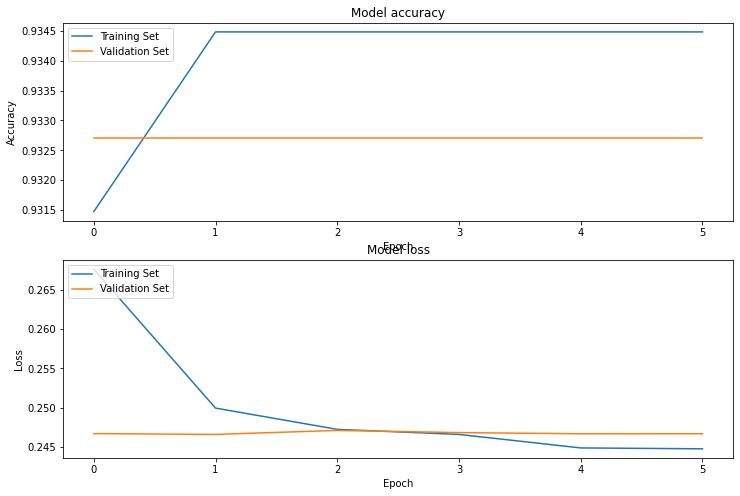

In [127]:
plot_history(history)

### Larger batch size

In [134]:
model1 = bankruptcy_model()
history1 = model.fit(X_train_scaled, y_train,
                    validation_data=(X_validate_scaled, y_validate),
                    epochs=25,
                    batch_size=300,
                    callbacks=callbacks)

Epoch 1/25
158/158 [==============================] - 1s 4ms/step - loss: 0.2428 - accuracy: 0.9345 - val_loss: 0.2466 - val_accuracy: 0.9327
Epoch 2/25
158/158 [==============================] - 1s 4ms/step - loss: 0.2427 - accuracy: 0.9345 - val_loss: 0.2466 - val_accuracy: 0.9327
Epoch 3/25
158/158 [==============================] - 1s 3ms/step - loss: 0.2430 - accuracy: 0.9345 - val_loss: 0.2466 - val_accuracy: 0.9327
Epoch 4/25
158/158 [==============================] - 0s 3ms/step - loss: 0.2428 - accuracy: 0.9345 - val_loss: 0.2466 - val_accuracy: 0.9327
Epoch 5/25
158/158 [==============================] - 0s 3ms/step - loss: 0.2426 - accuracy: 0.9345 - val_loss: 0.2466 - val_accuracy: 0.9327
Epoch 6/25
158/158 [==============================] - 1s 3ms/step - loss: 0.2427 - accuracy: 0.9345 - val_loss: 0.2466 - val_accuracy: 0.9327
Epoch 7/25
158/158 [==============================] - 0s 3ms/step - loss: 0.2426 - accuracy: 0.9345 - val_loss: 0.2466 - val_accuracy: 0.9327
Epoch 

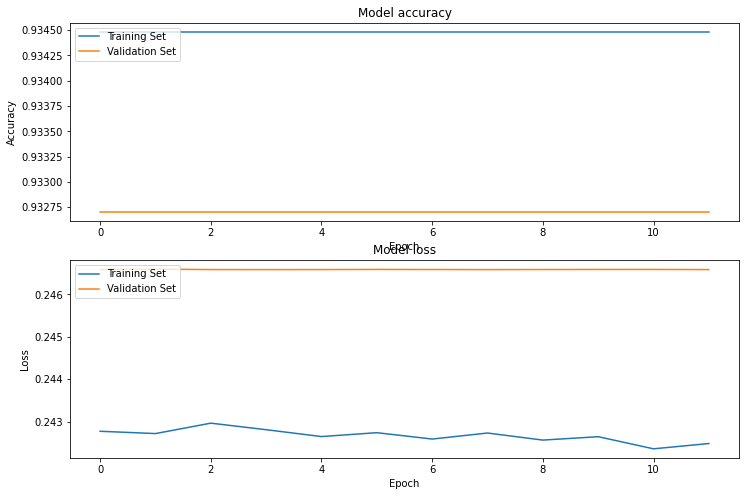

In [135]:
plot_history(history1)

## Model 2

In [145]:
model_v2 = bankruptcy_model_v2()
history_v2 = model_v2.fit(X_train_scaled, y_train,
                       validation_data=(X_validate_scaled, y_validate),
                       epochs=25,
                       batch_size=18,
                       callbacks=callbacks)

Epoch 1/25
2623/2623 [==============================] - 7s 2ms/step - loss: 0.2796 - accuracy: 0.9317 - val_loss: 0.2382 - val_accuracy: 0.9327
Epoch 2/25
2623/2623 [==============================] - 6s 2ms/step - loss: 0.2464 - accuracy: 0.9345 - val_loss: 0.2390 - val_accuracy: 0.9327
Epoch 3/25
2623/2623 [==============================] - 6s 2ms/step - loss: 0.2414 - accuracy: 0.9345 - val_loss: 0.2389 - val_accuracy: 0.9327
Epoch 4/25
2623/2623 [==============================] - 6s 2ms/step - loss: 0.2380 - accuracy: 0.9344 - val_loss: 0.2377 - val_accuracy: 0.9327
Epoch 5/25
2623/2623 [==============================] - 6s 2ms/step - loss: 0.2376 - accuracy: 0.9345 - val_loss: 0.2380 - val_accuracy: 0.9327
Epoch 6/25
2623/2623 [==============================] - 6s 2ms/step - loss: 0.2355 - accuracy: 0.9345 - val_loss: 0.2369 - val_accuracy: 0.9327
Epoch 7/25
2623/2623 [==============================] - 6s 2ms/step - loss: 0.2344 - accuracy: 0.9344 - val_loss: 0.2371 - val_accuracy:

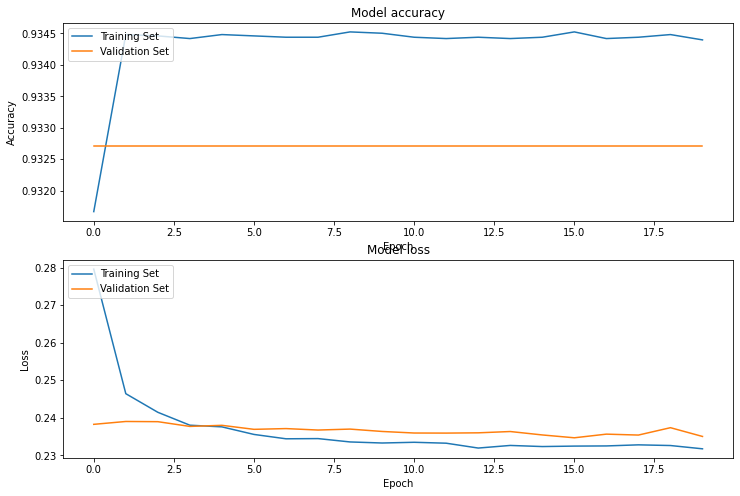

In [146]:
plot_history(history_v2)

## Model 3
### Hyperparm tuning

In [111]:
model_v3 = bankruptcy_model_v3()
model_v3.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
                 loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                 metrics=['accuracy'])
history_v3 = model_v3.fit(X_train_scaled, y_train,
                          validation_data=(X_validate_scaled, y_validate),
                          epochs=25,
                          batch_size=18,
                          callbacks=callbacks)

Epoch 1/25
2623/2623 [==============================] - 7s 2ms/step - loss: 0.2838 - accuracy: 0.9336 - val_loss: 0.2563 - val_accuracy: 0.9327
Epoch 2/25
2623/2623 [==============================] - 6s 2ms/step - loss: 0.2575 - accuracy: 0.9344 - val_loss: 0.2482 - val_accuracy: 0.9327
Epoch 3/25
2623/2623 [==============================] - 6s 2ms/step - loss: 0.2497 - accuracy: 0.9344 - val_loss: 0.2419 - val_accuracy: 0.9327
Epoch 4/25
2623/2623 [==============================] - 6s 2ms/step - loss: 0.2461 - accuracy: 0.9344 - val_loss: 0.2439 - val_accuracy: 0.9327
Epoch 5/25
2623/2623 [==============================] - 6s 2ms/step - loss: 0.2432 - accuracy: 0.9344 - val_loss: 0.2433 - val_accuracy: 0.9327
Epoch 6/25
2623/2623 [==============================] - 6s 2ms/step - loss: 0.2430 - accuracy: 0.9344 - val_loss: 0.2485 - val_accuracy: 0.9327
Epoch 7/25
2623/2623 [==============================] - 6s 2ms/step - loss: 0.2420 - accuracy: 0.9344 - val_loss: 0.2414 - val_accuracy:

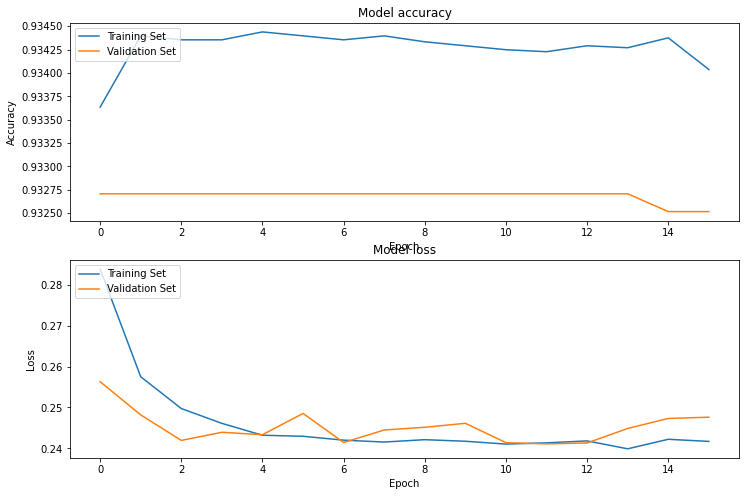

In [112]:
plot_history(history_v3)

In [197]:
model.predict(X_test)

492/492 [==============================] - 0s 540us/step


array([[0.06467962],
       [0.06467962],
       [0.06467962],
       ...,
       [0.06467962],
       [0.06467962],
       [0.06467962]], dtype=float32)

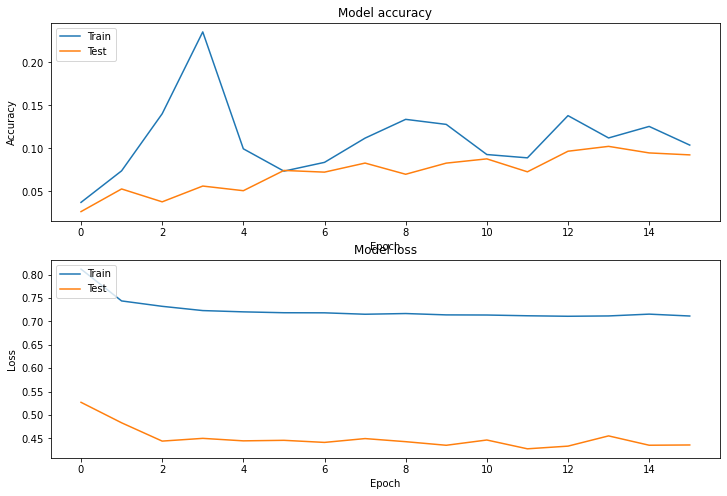

In [52]:
plot_history(history)

Text(0.5, 1.0, 'Correlation Matrix')

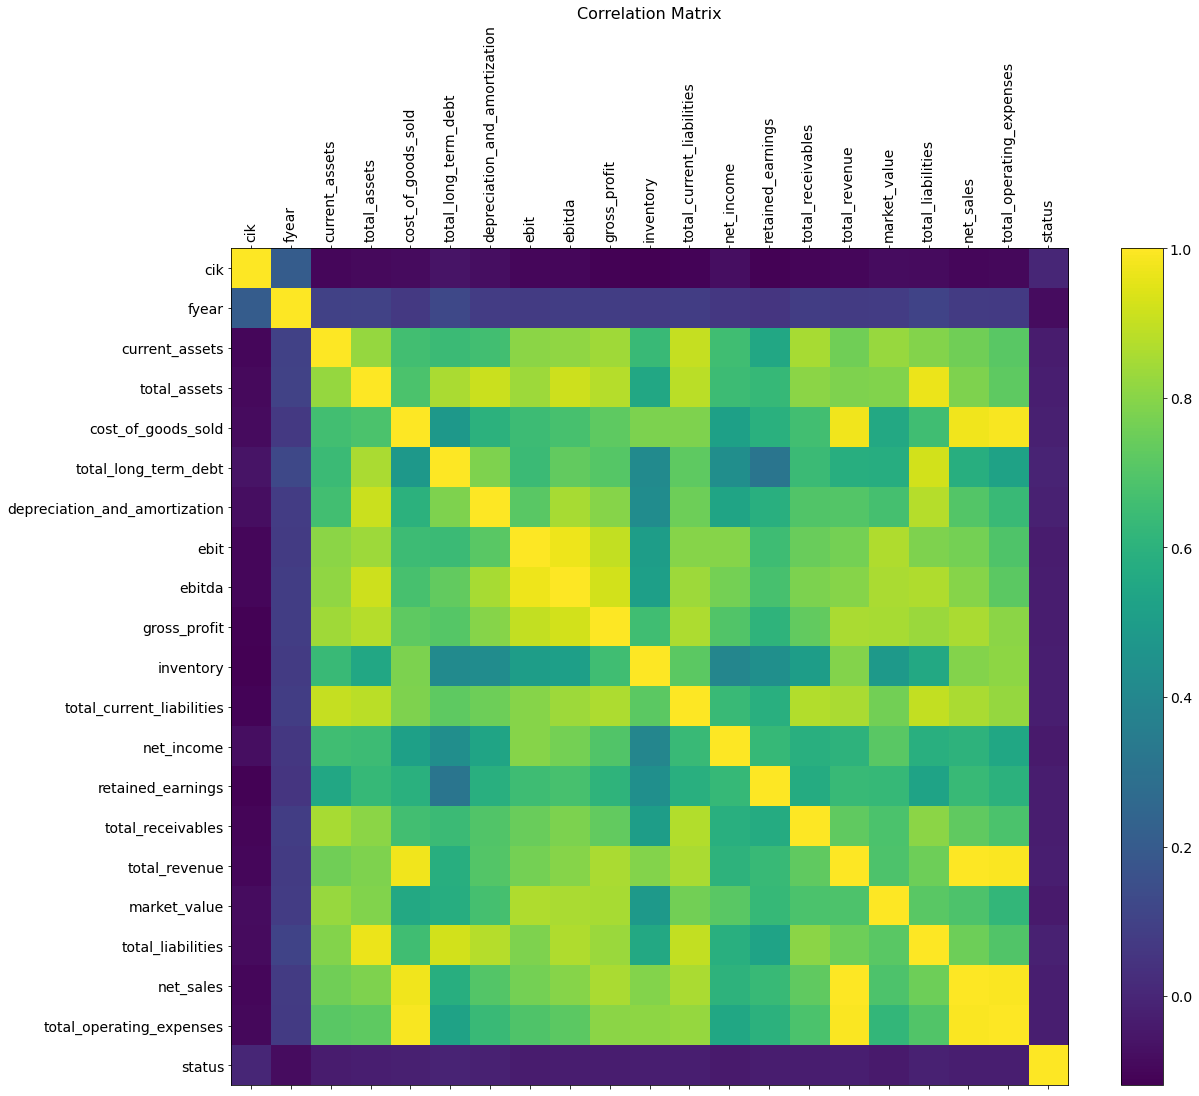

In [20]:
# Correlation Matrix
f = plt.figure(figsize=(19, 15))
plt.matshow(bank_data.corr(), fignum=f.number)

# only select numerical values
plt.xticks(range(bank_data.select_dtypes(['number']).shape[1]), bank_data.select_dtypes(['number']).columns, fontsize=14, rotation=90)
plt.yticks(range(bank_data.select_dtypes(['number']).shape[1]), bank_data.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)

In [21]:
# FIXME: Creare threshold (?) for predictions to make the only possible values 0 or 1
# Probably a better way to do this
predictions

array([[7.9327002e-02],
       [5.5738468e-02],
       [6.9394588e-02],
       ...,
       [4.8700053e-02],
       [1.3328383e-04],
       [9.4740182e-01]], dtype=float32)

In [15]:
# Confusion Matrix
# FIXME: Not workign yet due to predictions not beign 0 or 1

import seaborn as sns 
# Model improvement and Evaluation 
from sklearn import metrics 
from sklearn.metrics import confusion_matrix

# error solution - predictions to be converted to binary since the dataset is in binary and prediction should be binary as well.
threshold = 0.5
binary_predictions = [1 if p > threshold else 0 for p in predictions]

cm = pd.DataFrame(metrics.confusion_matrix(y_test, predictions))
print(cm)


ValueError: Classification metrics can't handle a mix of binary and continuous targets